## Example of using HGQ2 for multi-class classification over the small LHC jet dataset
##### This notebook requires scikit-learn, which is not required by HGQ2 in general.

In [1]:
import os
import random

# JAX runs the fastest for hgq in general based on our experience
# If you don't have jax, or if you want to use another backend, you can change this to 'tensorflow' or 'torch'
os.environ['KERAS_BACKEND'] = 'jax'
# tested for tensorflow, jax, torch. Openvino support is not tested yet.
# For the best performance, we recommend using jax, or tensorflow with XLA enabled.
# Jit compilation for torch (torch dynamo) is not supported yet.

import keras
import numpy as np
from matplotlib import pyplot as plt

from hgq.config import QuantizerConfig, QuantizerConfigScope
from hgq.layers import QDense, QSoftmax
from hgq.utils.sugar import FreeEBOPs, PBar

In [2]:
import pickle as pkl
from pathlib import Path

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def get_data(data_path: Path, seed=42):
    try:
        import zstd
    except ImportError:
        zstd = None
    if not os.path.exists(data_path):
        print('Downloading data...')
        data = fetch_openml('hls4ml_lhc_jets_hlf')
        buf = pkl.dumps(data)
        with open(data_path, 'wb') as f:
            if zstd is not None:
                buf = zstd.compress(buf)
            f.write(buf)
    else:
        os.makedirs(data_path.parent, exist_ok=True)
        with open(data_path, 'rb') as f:
            buf = f.read()
            if zstd is not None:
                buf = zstd.decompress(buf)
            data = pkl.loads(buf)

    X, y = data['data'], data['target']
    codecs = {'g': 0, 'q': 1, 't': 4, 'w': 2, 'z': 3}
    y = np.array([codecs[i] for i in y])

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    X_train_val, X_test, y_train_val, y_test = X_train_val.astype(np.float32), X_test.astype(np.float32), y_train_val, y_test

    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val)
    X_test = scaler.transform(X_test)

    X_train_val = X_train_val.astype(np.float32)
    y_train_val = y_train_val.astype(np.float32)

    return X_train_val, X_test, y_train_val, y_test


X_train, X_test, y_train, y_test = get_data(Path('/tmp/inp_data.zst'))

In [3]:
from hgq.utils.sugar import Dataset

In [4]:
_y_train = keras.utils.to_categorical(y_train, 5)
_y_test = keras.utils.to_categorical(y_test, 5)

dataset_train = Dataset(X_train, _y_train, batch_size=33200, device='gpu:0')
dataset_test = Dataset(X_test, _y_test, batch_size=33200, device='gpu:0')

In [5]:
np.random.seed(42)
random.seed(42)

In [6]:
from hgq.regularizers import MonoL1

# Skipping these should also work.
# Usually, the default configs are good enough for most cases, but the initial number of bits, `[bif]0`
# may need to be increased. If you see that the model is not converging, you can try increasing these values.
scope0 = QuantizerConfigScope(place='all', k0=1, b0=3, i0=0, default_q_type='kbi', overflow_mode='sat_sym')
scope1 = QuantizerConfigScope(place='datalane', k0=0, default_q_type='kif', overflow_mode='wrap', f0=3, i0=3)

exp_table_conf = QuantizerConfig('kif', 'table', k0=0, i0=1, f0=8, overflow_mode='sat_sym')
inv_table_conf = QuantizerConfig('kif', 'table', k0=1, i0=4, f0=4, overflow_mode='sat_sym')
# Layer scope will over formal one. When using scope0, scope1, 'datalane' config will be overriden with config in scope1

In [7]:
use_softmax = False
# QSoftmax is bit-accurate, but it can give exactly zero now: xentropy will diverge and thus USE WITH CAUTION
# For classification, it is recommended to NOT to use softmax in the model, but to use it in the loss function (see below)

In [8]:
def build_model(use_softmax=False, beta0=1e-5):
    with scope0, scope1:
        iq_conf = QuantizerConfig(place='datalane', k0=1)
        oq_conf = QuantizerConfig(place='datalane', k0=1, fr=MonoL1(1e-3))
        layers = [
            QDense(64, beta0=beta0, iq_conf=iq_conf, activation='relu', name='dense_0'),
            QDense(32, beta0=beta0, activation='relu', name='dense_1'),
            QDense(32, beta0=beta0, activation='relu', name='dense_2'),
            QDense(5, beta0=beta0, enable_oq=not use_softmax, name='dense_3', oq_conf=oq_conf),
            # QEinsumDense('...c,oc->...o', 64, bias_axes='o', beta0=beta0, iq_conf=iq_conf, activation='relu', bame='dense_0'),
            # QEinsumDense('...c,oc->...o', 32, bias_axes='o', beta0=beta0, activation='relu', name='dense_1'),
            # QEinsumDense('...c,oc->...o', 32, bias_axes='o', beta0=beta0, activation='relu', name='dense_2'),
            # QEinsumDense('...c,oc->...o', 5, bias_axes='o', beta0=beta0, enable_oq=not use_softmax, name='dense_3'),
        ]
        if use_softmax:
            layers.append(QSoftmax(exp_oq_conf=exp_table_conf, inv_oq_conf=inv_table_conf))

    model = keras.models.Sequential(layers)
    return model

In [9]:
model = build_model(use_softmax=use_softmax, beta0=0.5e-5)
if not use_softmax:
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
else:
    loss = keras.losses.CategoricalHinge()
opt = keras.optimizers.Adam(learning_rate=5e-3)

model.compile(opt, loss, metrics=['accuracy'], jit_compile=True, steps_per_execution=4)

In [10]:
pbar = PBar('loss: {loss:.3f}/{val_loss:.3f} - acc: {accuracy:.3f}/{val_accuracy:.3f}')
ebops = FreeEBOPs()
nan_terminate = keras.callbacks.TerminateOnNaN()
callbacks = [ebops, pbar, nan_terminate]

In [11]:
history = model.fit(dataset_train, epochs=3000, batch_size=33200, validation_data=dataset_test, verbose=0, callbacks=callbacks)

loss: 0.708/0.680 - acc: 0.756/0.757 - EBOPs: 3,909: 100%|██████████| 3000/3000 [00:55<00:00, 54.20epoch/s]


In [12]:
model.evaluate(dataset_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7570 - loss: 0.6799  


[0.6800289750099182, 0.7569397687911987]

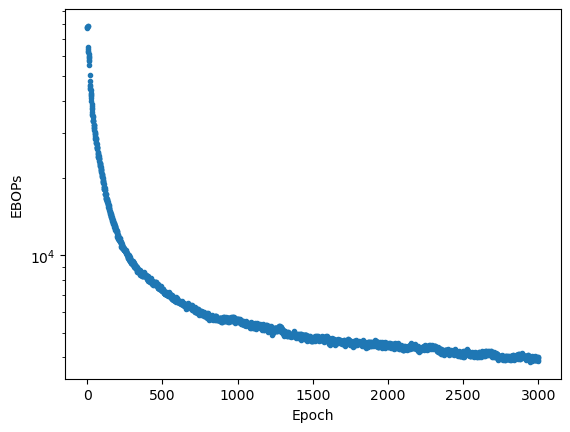

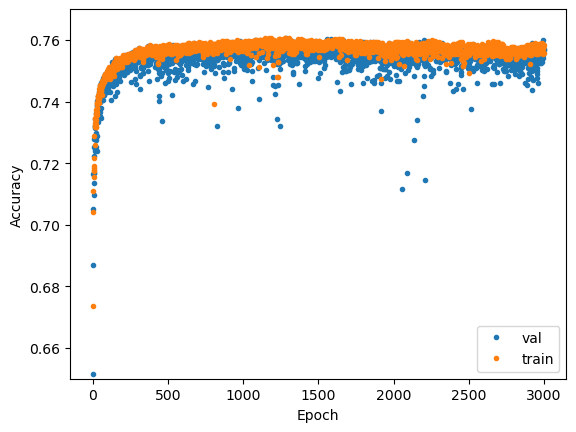

In [13]:
plt.plot(history.history['ebops'], '.')
plt.ylabel('EBOPs')
plt.yscale('log')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['val_accuracy'], '.', label='val')
plt.plot(history.history['accuracy'], '.', label='train')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim(0.65, 0.77)
plt.xlabel('Epoch')
plt.show()

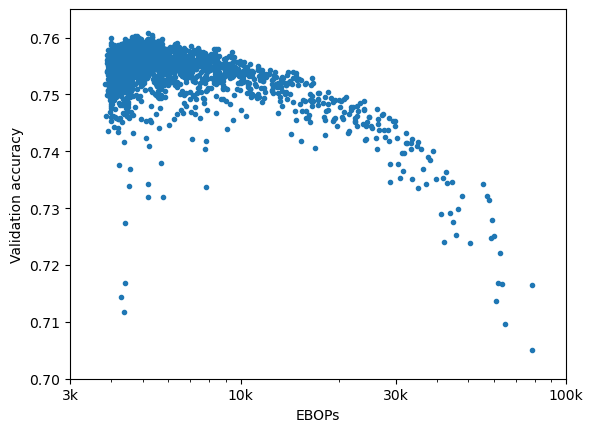

In [14]:
plt.plot(history.history['ebops'], history.history['val_accuracy'], '.')
plt.xscale('log')
plt.xlabel('EBOPs')
plt.ylabel('Validation accuracy')
plt.ylim(0.7, 0.765)
plt.xticks([3000, 10000, 30000, 100000], ['3k', '10k', '30k', '100k'])
plt.show()

In [15]:
from hls4ml.converters import convert_from_keras_model

In [16]:
# Similar to HGQ v1, if WRAP overflow mode is used for datalane, one needs to calibrate the number of integer bits
# before deployment to avoid overflow. This can be done by running the following code:
# Notice that `cover_factor` in HGQ v1 is not yet supported in this version.

from hgq.utils import trace_minmax

trace_minmax(model, dataset_train)

In [17]:
model_hls = convert_from_keras_model(model, output_dir='/tmp/tt')
model_hls.compile()

Writing HLS project


2025-03-14 20:24:25.902910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 20:24:25.910660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 20:24:25.913052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done


In [18]:
p_keras_train = model.predict(dataset_train, verbose=0)
p_hls_train = model_hls.predict(np.ascontiguousarray(X_train))

p_keras = model.predict(dataset_test, verbose=0)
p_hls = model_hls.predict(np.ascontiguousarray(X_test))

In [19]:
n_mismatch_train = np.sum(p_keras_train != p_hls_train)
n_mismatch = np.sum(p_keras != p_hls)
n_train = np.prod(p_keras_train.shape)
n = np.prod(p_keras.shape)

print(f'Training set mismatch: {n_mismatch_train}/{n_train} ({n_mismatch_train/n_train:.2%})')
print(f'Test set mismatch: {n_mismatch}/{n} ({n_mismatch/n:.2%})')

Training set mismatch: 0/3320000 (0.00%)
Test set mismatch: 0/830000 (0.00%)
